# Fitting the transfer function of a coupled oscillator
This section will be undoubtedly very useful for KAGRA's suspension modeling, as the transfer functions of the suspensions all behave like oscillator. Different from that in the previous tutorials, the transfer function of osciilators has complex poles and zeros instead of simple poles and zeros. Typically, they can be represented by the model

\begin{equation}
    G(s; z_i, q_i, p_j, Q_j, k) = k\frac{\prod_i \left(\frac{1}{(2\pi z_i)^2} s^2 + \frac{1}{2\pi z_i q_i}s + 1\right)}{\prod_j \left(\frac{1}{(2\pi p_j)^2} s^2 + \frac{1}{2\pi p_j Q_j}s + 1\right)}\,,
\end{equation}
where $z_i$ and $p_j$ are the resonance frequencies of the complex zeros and poles respectively, $q_i$ and $Q_j$ are the quality factors of the complex zeros and poles respectively, and $k$ is the static gain. And because of the similarity to the simple ZPK model, we call this a complex ZPK model.

Typically it's sufficient to consider the model
\begin{equation}
    H(s; k_i, f_i, q_i) = \sum_i k_i\frac{(2\pi f_i)^2}{s^2 + \frac{2\pi f_i}{q_i} s + (2\pi f_i)^2}\,.
\end{equation}
This model has fewer parameters than $G(s)$, but it only works for second-order systems, i.e. input-output relationship of a single stage. $G(s)$ is a more general representation so this is what we will use here.

In this tutorial, we will consider the following transfer function
\begin{equation}
 F(s) = 10\frac{(2\pi)^2}{s^2 + \frac{2\pi}{10}s + (2\pi)^2} + 1\frac{(10*2\pi)^2}{s^2 + \frac{10*2\pi}{100}s + (10*2\pi)^2}\,.
\end{equation}
And, we will try to fit it with the model $G(s)$

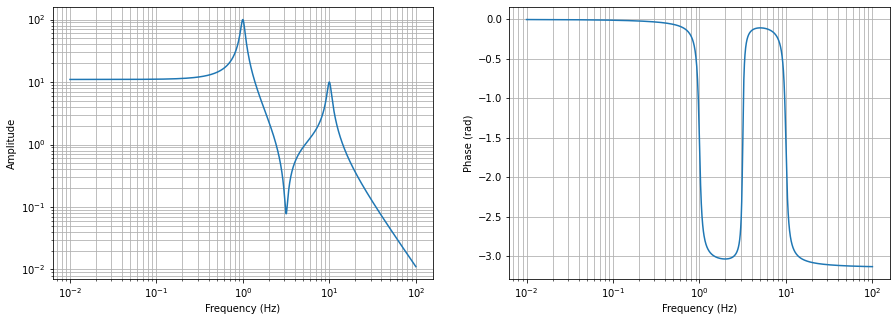

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt


s = control.tf("s")
tf = 10*(2*np.pi)**2/(s**2 + (1*2*np.pi)/10*s + (2*np.pi)**2) + 1*(10*2*np.pi)**2/(s**2 + (10*2*np.pi)/10*s + (10*2*np.pi)**2)
f = np.linspace(0.01, 100, 10000)
tf_val = tf(1j*2*np.pi*f)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf_val))
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf_val))
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

Here will we show how we can obtain an inital guess for the fit.

Judging from the plot, we should expect two complex poles at around 1 and 10 Hz, and a complex zeros at around 3 Hz. We will hand fit the transfer function as an initial guess. We start from lowest frequency, so it's just a gain at around 10.

\begin{equation}
    G_0(s) = 10
\end{equation}

And then, we scan from low frequency to high frequency. The next thing we see is a peak, which correspond to a pair of complex poles.
So, we add a pair of complex poles at 1 Hz and we fine tune the Q to match the peak, to which it becomes

\begin{equation}
    G_1(s) = G_0(s)  \frac{1}{\frac{1}{(1*2\pi)^2}s^2 + \frac{1}{1*2\pi Q_1}s + 1}\,,
\end{equation}
wherer $Q_1$ is around 10.

Then, the next feature is a notch at 3 Hz, which corresponds to a pair of complex zeros.
So we add a pair of complex zeros at 3 Hz, and tune the Q value to match the depth.
So it becomes

\begin{equation}
    G_2(s) = G_1(s)  \frac{\frac{1}{(3*2\pi)^2}s^2 + \frac{1}{3*2\pi q_2}s + 1}{1}\,,
\end{equation}
where we pick $q_2=10$

The last feature is a peak at 10 Hz, so we will add a pair of complex poles at 10 Hz.
And finally, the 
\begin{equation}
    G_3(s) = G_2(s)  \frac{1}{\frac{1}{(10*2\pi)^2}s^2 + \frac{1}{10*2\pi Q_3}s + 1}\,,
\end{equation}
where we pick $Q_3$ to be 20.


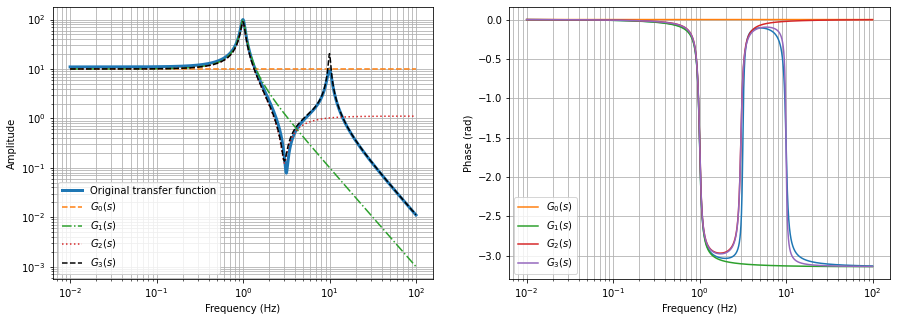

In [2]:
import kontrol.curvefit

G0 = kontrol.curvefit.model.ComplexZPK(nzero_pairs=0, npole_pairs=0)
G0_args = [10]

G1 = kontrol.curvefit.model.ComplexZPK(nzero_pairs=0, npole_pairs=1)
G1_args = [1, 10, 10]

G2 = kontrol.curvefit.model.ComplexZPK(nzero_pairs=1, npole_pairs=1)
G2_args = [3, 10, 1, 10, 10]

G3 = kontrol.curvefit.model.ComplexZPK(nzero_pairs=1, npole_pairs=2)
G3_args = [3, 10, 1, 10, 10, 20, 10]

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf_val), label="Original transfer function", lw=3)
plt.loglog(f, abs(G0(f, G0_args)), label="$G_0(s)$", ls="--")
plt.loglog(f, abs(G1(f, G1_args)), label="$G_1(s)$", ls="-.")
plt.loglog(f, abs(G2(f, G2_args)), label="$G_2(s)$", ls=":")
plt.loglog(f, abs(G3(f, G3_args)), label="$G_3(s)$", color="k", ls="--")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

plt.subplot(122)
plt.semilogx(f, np.angle(tf_val))
plt.semilogx(f, np.angle(G0(f, G0_args)), label="$G_0(s)$")
plt.semilogx(f, np.angle(G1(f, G1_args)), label="$G_1(s)$")
plt.semilogx(f, np.angle(G2(f, G2_args)), label="$G_2(s)$")
plt.semilogx(f, np.angle(G3(f, G3_args)), label="$G_3(s)$")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()


As can be seen, adding zeros/poles at higher frequencies doesn't affect the features at lower frequencies. This is why we started adding features from lower to higher frequencies.

The final initial guess we obtained is a ``kontrol.curvefit.model.ComplexZPK`` model, with parameters ``[3, 10, 1, 10, 10, 20, 10]``.
The arguments are arranged in the form ``[z_i, q_i, p_j, Q_j, k]``. 
We specified the number of complex zero pairs ``nzero_pairs`` and the number of complex pole pairs ``npole_pairs`` during the model declaration so the program knows how to slices the parameters.
So in this case, the first two values correspond to a pair of complex zeros at 3 Hz with Q-value of 10.
The second two values correspond to a pair of complex poles at 1 Hz with Q-value of 10, and so on.
But this initial guess is probably too good to start with, so we add some noise to it to mimic a realistic fit.

Now we can proceed to the usual curve fitting routine.

In [3]:
import scipy.optimize
import kontrol.curvefit

a = kontrol.curvefit.CurveFit()
a.xdata = f
a.ydata = tf_val
a.model = kontrol.curvefit.model.ComplexZPK(nzero_pairs=1, npole_pairs=2)

error_func = kontrol.curvefit.error_func.tf_error
weight = 1/f
error_func_kwargs = {"weight": weight}
a.cost = kontrol.curvefit.Cost(error_func=error_func, error_func_kwargs=error_func_kwargs)
a.optimizer = scipy.optimize.minimize

np.random.seed(123)
noise = np.random.normal(0, np.array(G3_args)/10)
# print(noise)
x0 = np.array(G3_args) + noise
a.optimizer_kwargs = {"x0": x0}
res = a.fit()

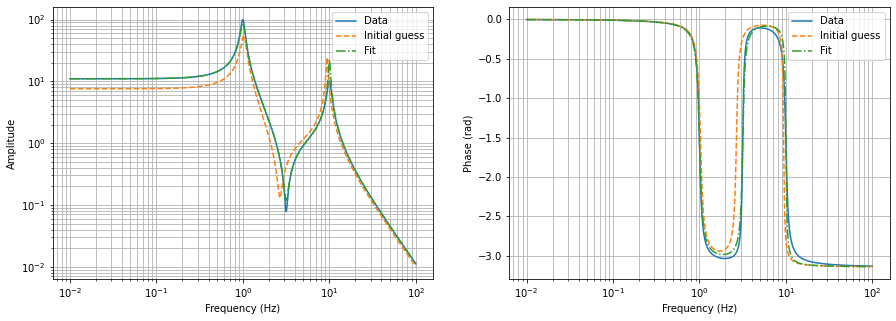

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf_val), label="Data")
plt.loglog(f, abs(a.model(f, x0)), label="Initial guess", ls="--")
plt.loglog(f, abs(a.yfit), label="Fit", ls="-.")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf_val), label="Data")
plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess", ls="--")
plt.semilogx(f, np.angle(a.yfit), label="Fit", ls="-.")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

Again, because the parameters can be bounded, we can use global optimization without an initial guess.
Let's just demonstrate once again.

In [5]:
# Using log scale this time.
bounds = [(np.log10(min(f)), np.log10(max(f))), (np.log10(0.5), np.log10(1e3))]*3
bounds += [(np.log10(abs(tf_val[0])/10), np.log10(abs(tf_val[0])*10))]

a.model = kontrol.curvefit.model.ComplexZPK(nzero_pairs=1, npole_pairs=2, log_args=True)
a.optimizer = scipy.optimize.differential_evolution
a.optimizer_kwargs = {"bounds": bounds, "workers": -1, "updating": "deferred"}

np.random.seed(123)
res = a.fit()

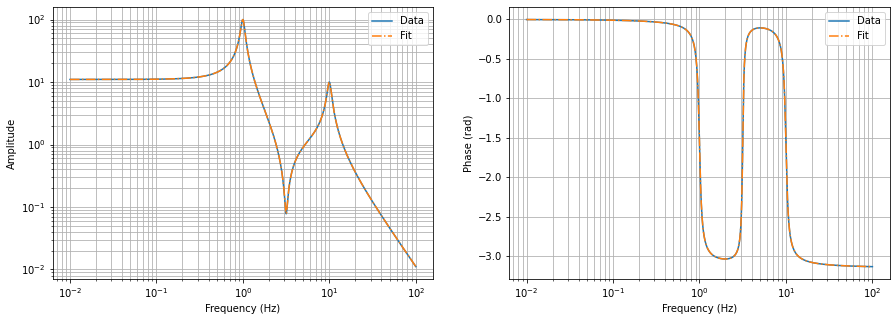

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf_val), label="Data")
# plt.loglog(f, abs(a.model(f, x0)), label="Initial guess", ls="--")
plt.loglog(f, abs(a.yfit), label="Fit", ls="-.")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf_val), label="Data")
# plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess", ls="--")
plt.semilogx(f, np.angle(a.yfit), label="Fit", ls="-.")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

And, it worked very well.